# Normative modelling tutorial

Welcome to this tutorial notebook that will go through the fitting, evaluation, transfering, and extending of Normative models. 

Let's jump right in.

### Imports

In [1]:
import warnings
import logging


import pandas as pd
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model import NormativeModel
from pcntoolkit.regression_model.hbr import HBR, make_prior
from pcntoolkit.util.plotter import plot_centiles, plot_qq
from pcntoolkit.regression_model.hbr import NormalLikelihood, SHASHbLikelihood
from pcntoolkit.regression_model.blr import BLR
from pcntoolkit.math.basis_function import BsplineBasisFunction
import numpy as np
import pcntoolkit.util.output
import seaborn as sns
import os

# Suppress some annoying warnings and logs
pymc_logger = logging.getLogger("pymc")

pymc_logger.setLevel(logging.WARNING)
pymc_logger.propagate = False

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pcntoolkit.util.output.Output.set_show_messages(False)

# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [2]:
# If you are running this notebook for the first time, you need to download the dataset from github.
if not os.path.exists("resources/data/fcon1000.csv"):
    pd.read_csv(
        "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
    ).to_csv("resources/data/fcon1000.csv", index=False)

# Read the data from the CSV file.
data = pd.read_csv("resources/data/fcon1000.csv")
# Map the sex column to "Male" and "Female"
data["sex"] = np.where(data["sex"], "Male", "Female")
# Define which columns are covariates and batch effects
covariates = ["age"]
batch_effects = ["sex", "site"]
# Define which columns are response variables
response_vars = ["WM-hypointensities", "rh_MeanThickness_thickness"]
# response_vars = ["rh_MeanThickness_thickness"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_vars,
)

# Leave two sites out for doing transfer and extend later
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects({"site": transfer_sites}, names=("transfer", "fit"))

# Split into train and test sets
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()


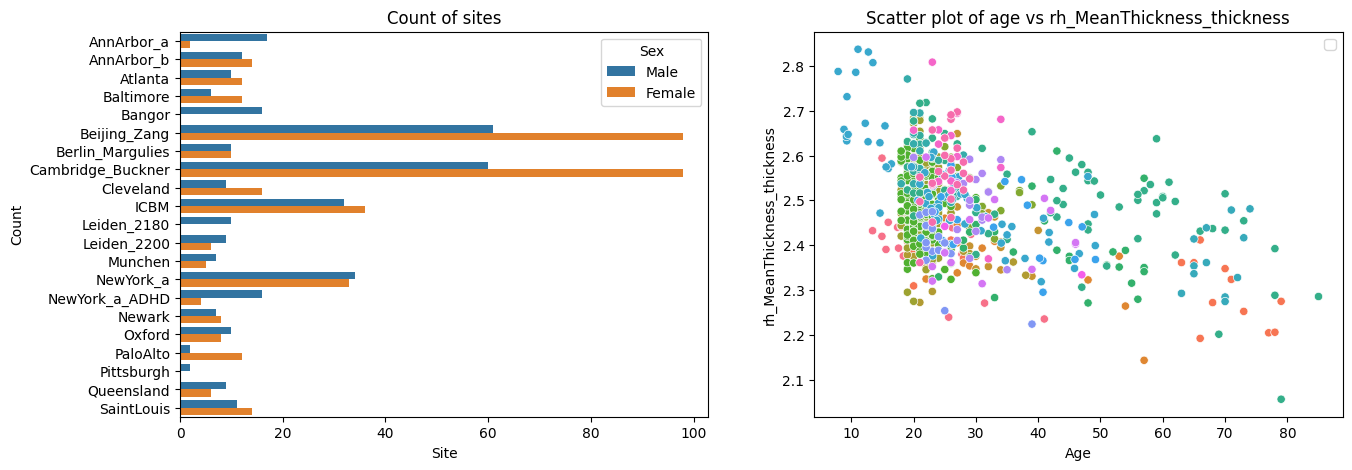

In [3]:
# Inspect the data
df = train.to_dataframe()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=df, x=("X", "age"), y=("Y", "rh_MeanThickness_thickness"), hue=("batch_effects", "site"), ax=ax[1])
ax[1].legend([], [])
ax[1].set_title("Scatter plot of age vs rh_MeanThickness_thickness")
ax[1].set_xlabel("Age")
ax[1].set_ylabel("rh_MeanThickness_thickness")
sns.countplot(data=df, y=("batch_effects", "site"), hue=("batch_effects", "sex"), ax=ax[0], orient="h")
ax[0].legend(title="Sex")
ax[0].set_title("Count of sites")
ax[0].set_xlabel("Site")
ax[0].set_ylabel("Count")
plt.show()

# Creating a Normative model

A normative model has a regression model for each response variable. We provide a template regression model which is copied for each response variable. 

A template regression model can be anything that implements the `RegressionModel` interface. We provide a number of built-in regression models, or you can easily create your own. 

Here we use the `HBR` class, which implements a Hierarchical Bayesian Regression model. 

The `HBR` class needs to know which likelihood function to use. We can either use a Normal, SHASHo, SHASHb, or Beta likelihood. Each of these likelihood functions has a number of parameters that need to be specified. 

Here we use the Normal likelihood. This takes a mu and a sigma parameter, which can be created using the `make_prior` function, or by providing the 'Prior' directly. 

Here we use the `make_prior` function to create the parameters. 

In [4]:
mu = make_prior(
    # Mu is linear because we want to allow the mean to vary as a function of the covariates.
    linear=True,
    # The slope coefficients are assumed to be normally distributed, with a mean of 0 and a standard deviation of 10.
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 10.0)),
    # The intercept is random, because we expect the intercept to vary between sites and sexes.
    intercept=make_prior(
        random=True,
        # Mu is the mean of the intercept, which is normally distributed with a mean of 0 and a standard deviation of 1.
        mu=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
        # Sigma is the scale at which the intercepts vary. It is a positive parameter, so we use a half-normal distribution.
        sigma=make_prior(dist_name="Gamma", dist_params=(3.0, 1.0)),
    ),
    # We use a B-spline basis function to allow for non-linearity in the mean.
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
)
sigma = make_prior(
    # Sigma is also linear, because we want to allow the standard deviation to vary as a function of the covariates: heteroskedasticity.
    linear=True,
    # The slope coefficients are assumed to be normally distributed, with a mean of 0 and a standard deviation of 2.
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 2.0)),
    # The intercept is random, because we expect the intercept to vary between sites and sexes.
    intercept=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
    # We use a B-spline basis function to allow for non-linearity in the standard deviation.
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
    # We use a softplus mapping to ensure that sigma is strictly positive.
    mapping="softplus",
    # We scale the softplus mapping by a factor of 3, to avoid spikes in the resulting density.
    # The parameters (a, b, c) provided to a mapping f are used as: f_abc(x) = f((x - a) / b) * b + c
    # This basically provides an affine transformation of the softplus function.
    # a -> horizontal shift
    # b -> scaling
    # c -> vertical shift
    # You can leave c out, and it will default to 0.
    mapping_params=(0.0, 3.0),
)


template_hbr = HBR(
    # The name of the model.
    name="template",
    # The number of cores to use for sampling.
    cores=16,
    # Whether to show a progress bar during the model fitting.
    progressbar=True,
    # The number of draws to sample from the posterior per chain.
    draws=1500,
    # The number of tuning steps to run.
    tune=500,
    # The number of MCMC chains to run.
    chains=4,
    # The sampler to use for the model.
    nuts_sampler="nutpie",
    # The likelihood function to use for the model.
    likelihood=NormalLikelihood(
        mu,
        sigma,
    ),
)

After specifying the regression model, we can configure a normative model. 

A normative model has a number of configuration options:
- `savemodel`: Whether to save the model after fitting.
- `evaluate_model`: Whether to evaluate the model after fitting.
- `saveresults`: Whether to save the results after evaluation.
- `saveplots`: Whether to save the plots after fitting.
- `save_dir`: The directory to save the model, results, and plots.
- `inscaler`: The scaler to use for the input data.
- `outscaler`: The scaler to use for the output data.




In [5]:
# BLR model
blr_regression_model = BLR(
    name="template",
    n_iter=1000,
    tol=1e-8,
    optimizer="l-bfgs-b",
    l_bfgs_b_epsilon=0.1,
    l_bfgs_b_l=0.1,
    l_bfgs_b_norm="l2",
    fixed_effect=True,
    intercept=True,
    basis_function_mean=BsplineBasisFunction(basis_column=0, degree=3, nknots=5),
    heteroskedastic=True,
    basis_function_var=BsplineBasisFunction(basis_column=0, degree=3, nknots=5),
    intercept_var=True,
    fixed_effect_var=True,
)

In [6]:
model = NormativeModel(
    # The regression model to use for the normative model.
    template_regression_model=blr_regression_model,
    # Whether to save the model after fitting.
    savemodel=True,
    # Whether to evaluate the model after fitting.
    evaluate_model=True,
    # Whether to save the results after evaluation.
    saveresults=True,
    # Whether to save the plots after fitting.
    saveplots=True,
    # The directory to save the model, results, and plots.
    save_dir="resources/blr/save_dir",
    # The scaler to use for the input data. Can be either one of "standardize", "minmax", "robustminmax", "none"
    inscaler="standardize",
    # The scaler to use for the output data. Can be either one of "standardize", "minmax", "robustminmax", "none"
    outscaler="standardize",
)

# Fit the model


With all that configured, we can fit the model. 

The `fit_predict` function will fit the model, evaluate it, and save the results and plots (if so configured). 

After that, it will compute Z-scores and centiles for the test set. 

All results can be found in the save directory. 

In [7]:
test = model.fit_predict(train, test)

# Now what?

Now we have a normative model, we can use it to:
- Harmonize data
- Synthesize data
- Map data to Z-scores
- Plot centiles
- Plot QQ-plots
- Save the model
- Send it to a colleague
- Load it from file
- Transfer the model to another dataset
- Extend the model to another dataset

In [8]:
# turn this off because it costs time
model.savemodel = False
model.saveresults = False
model.saveplots = False
model.evaluate_model = False

### Harmonize

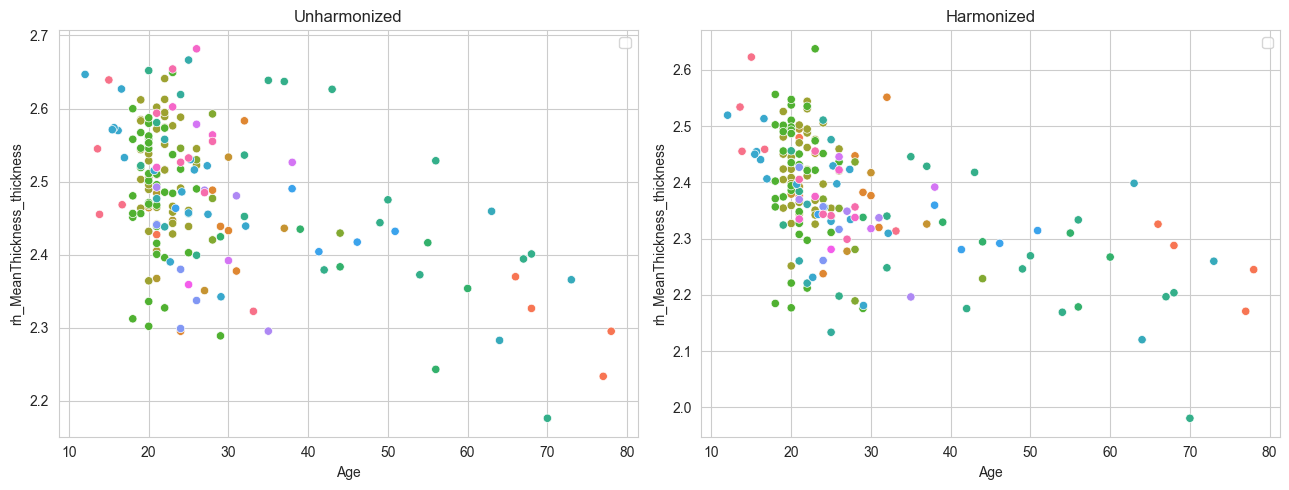

In [9]:
model.harmonize(test)  # <- easy

df = test.to_dataframe()
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
sns.scatterplot(data=df, x=("X", "age"), y=("Y", "rh_MeanThickness_thickness"), hue=("batch_effects", "site"), ax=ax[0])
sns.scatterplot(
    data=df, x=("X", "age"), y=("Y_harmonized", "rh_MeanThickness_thickness"), hue=("batch_effects", "site"), ax=ax[1]
)
ax[0].title.set_text("Unharmonized")
ax[1].title.set_text("Harmonized")
ax[0].legend([], [])
ax[1].legend([], [])
ax[0].set_xlabel("Age")
ax[0].set_ylabel("rh_MeanThickness_thickness")
ax[1].set_xlabel("Age")
ax[1].set_ylabel("rh_MeanThickness_thickness")
plt.tight_layout()
plt.show()

### Synthesize

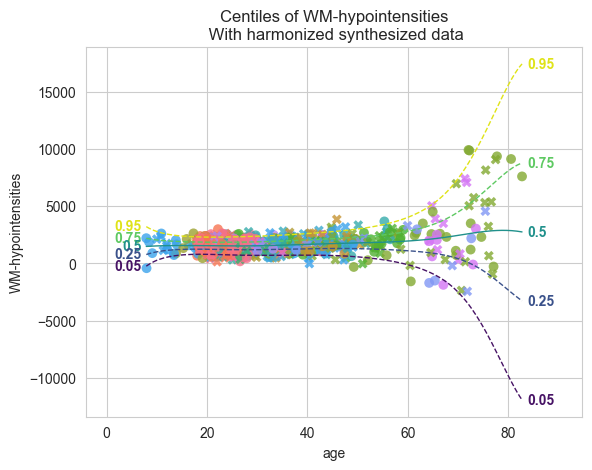

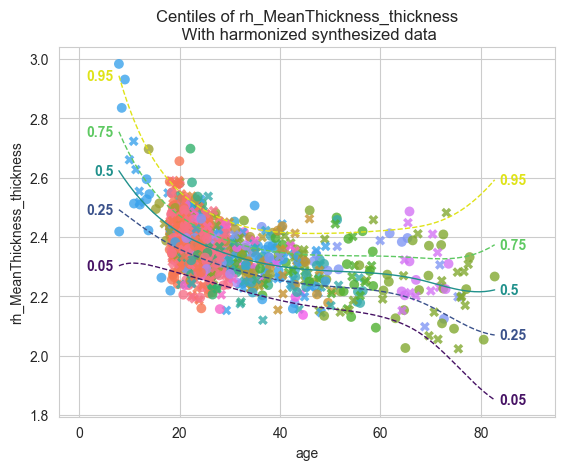

In [10]:
synthetic_data = model.synthesize()  # <- also easy
plot_centiles(
    model,
    synthetic_data,  # Which data to base the plot on
    covariate="age",  # Which covariate to plot on the x-axis
    batch_effects="all",  # You can set this to "all" to show all batch effects
    show_data=True,  # Show the data points
    show_other_data=True,  # Show data points that do not match any batch effects
    harmonize_data=True,  # Set this to False to see the difference
    show_legend=False,
)


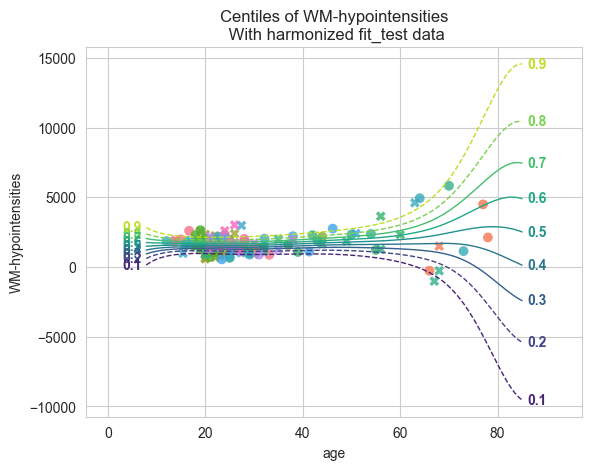

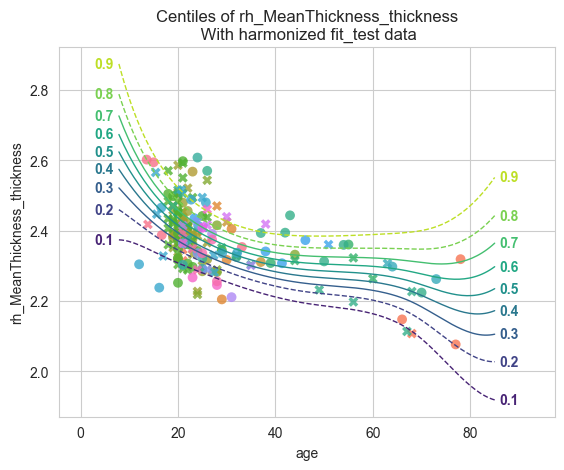

In [11]:
# Synthesize new Y data for existing X data
new_test_data = test.copy()

if hasattr(new_test_data, "Y"):
    del new_test_data["Y"]

synthetic = model.synthesize(new_test_data)  # <- will fill in the missing Y data
plot_centiles(
    model,
    synthetic,  # Which data to base the plot on
    centiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    covariate="age",  # Which covariate to plot on the x-axis
    batch_effects="all",  # You can set this to "all" to show all batch effects
    show_data=True,  # Show the data points
    show_other_data=True,  # Show data points that do not match any batch effects
    harmonize_data=True,  # Set this to False to see the difference
    show_legend=False,
)

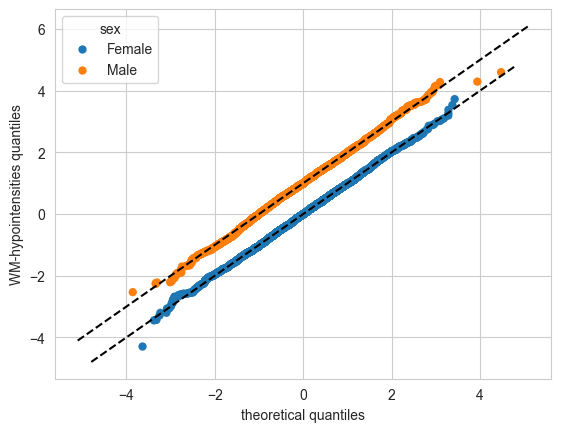

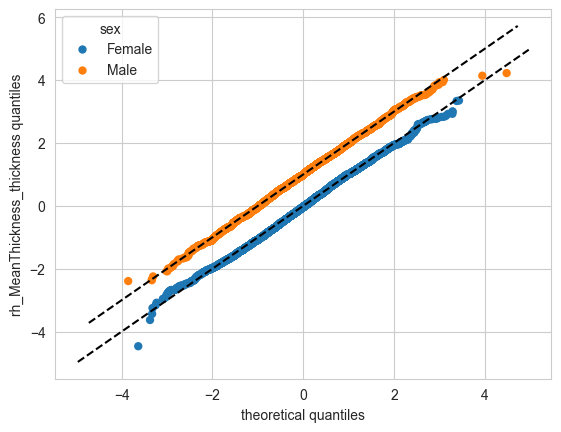

In [12]:
plot_qq(model.synthesize(n_samples=10000), plot_id_line=True, hue_data="sex", split_data="sex")

In [13]:
# Map data to Z-scores
if hasattr(test, "Z"):
    del test["Z"]
test = model.predict(test)
display(test["Z"].to_pandas())

response_vars,WM-hypointensities,rh_MeanThickness_thickness
datapoints,,
515,-0.444500,-0.724980
441,-0.553731,-0.347662
1029,0.789784,0.817985
64,0.488662,-1.932138
654,-0.731919,0.637791
...,...,...
611,1.371303,-1.410164
549,2.600811,-1.241929
640,-0.386203,-0.466251


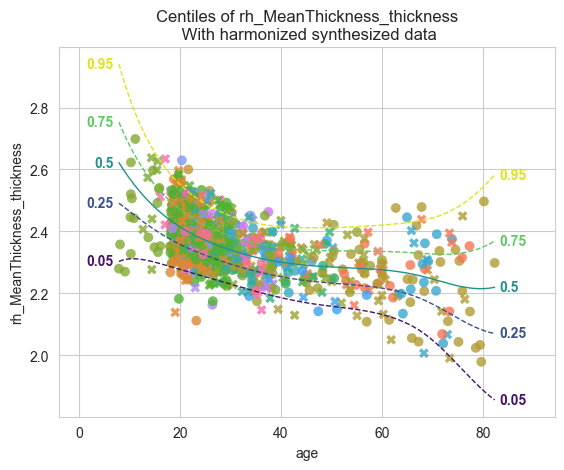

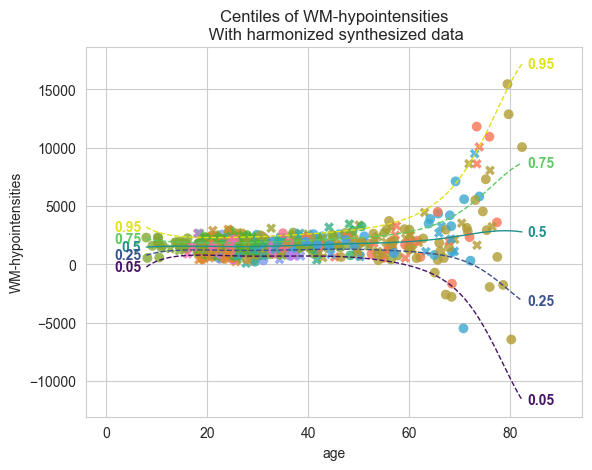

In [14]:
model.save("resources/save_me_here")
loaded_model = NormativeModel.load("resources/save_me_here")
synth = loaded_model.synthesize()
plot_centiles(
    loaded_model,
    synth,
    covariate="age",
    batch_effects="all",
    show_data=True,
    show_other_data=True,
    harmonize_data=True,
    show_legend=False,
)


### Transfer and extend

We can transfer the model to a new dataset with new sites. Then we will be able to use it on the new dataset.

We can also extend the model to a new dataset. Then we will be able to use it on the new dataset as well as the old one.

Both are possible without access to the original data.

Isn't that cool?

In [15]:
# Turn this back on
model.savemodel = True
model.saveresults = True
model.saveplots = True
model.evaluate_model = True

In [16]:
transfered_model = model.transfer(transfer_train, freedom=0.00001)
transfered_model.predict(transfer_test)
plot_centiles(
    transfered_model,
    transfer_train,
    covariate="age",
    batch_effects="all",
    show_data=True,
    show_other_data=True,
    harmonize_data=True,
    show_legend=True,
)

ValueError: Process: 43516 - BLR transfer not implemented

In [17]:
transfered_model.model_specific_evaluation()

NameError: name 'transfered_model' is not defined

In [18]:
# And extend the model to a new dataset
extended_model = model.extend(transfer_train)
extended_model.predict(transfer_test)

<xarray.NormData> Size: 9kB
Dimensions:            (response_vars: 2, datapoints: 30, covariates: 1,
                        batch_effect_dims: 2, centile: 5, measure: 8)
Coordinates:
  * response_vars      (response_vars) <U26 208B 'WM-hypointensities' 'rh_Mea...
  * datapoints         (datapoints) int64 240B 951 953 915 943 ... 973 908 976
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * centile            (centile) float64 40B 0.05 0.25 0.5 0.75 0.95
  * measure            (measure) <U8 256B 'MSLL' 'NLL' ... 'SMSE' 'ShapiroW'
Data variables:
    Y                  (datapoints, response_vars) float64 480B 1.287e+03 ......
    X                  (datapoints, covariates) float64 240B 21.0 22.0 ... 21.0
    batch_effects      (datapoints, batch_effect_dims) <U11 3kB 'Female' ... ...
    Z                  (datapoints, response_vars) float64 480B 0.04878 ... 0...
    centiles           (centile, datapoints, response_vars) float64 2kB 467.1...
    logp               (datapoints, response_vars) float64 480B -0.4078 ... -...
    Yhat               (datapoints, response_vars) float64 480B 1.264e+03 ......
    measures           (response_vars, measure) float64 128B 6.587 ... 0.9697
    Y_harmonized       (datapoints, response_vars) float64 480B 989.9 ... 2.603
Attributes:
    is_scaled:                      False
    name:                           transfer_test
    unique_batch_effects:           {'sex': ['Female', 'Male'], 'site': ['Mil...
    batch_effect_counts:            {'sex': {'Female': 96, 'Male': 52}, 'site...
    batch_effect_covariate_ranges:  {'sex': {'Female': {'age': {'min': 20.0, ...
    covariate_ranges:               {'age': {'min': 20.0, 'max': 65.0}}

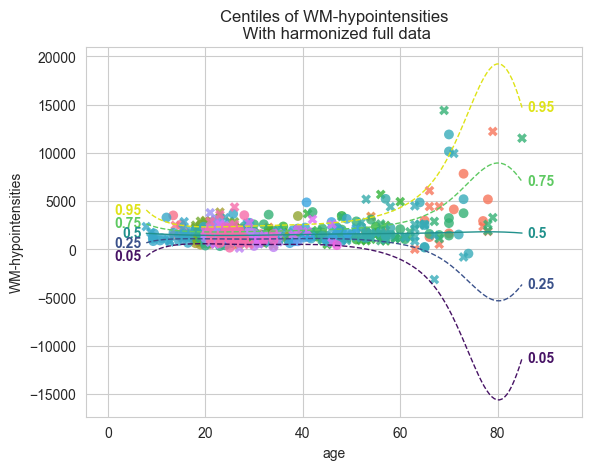

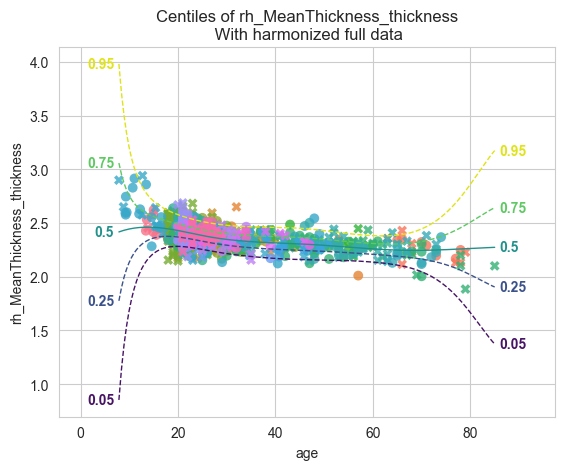

In [19]:
plot_centiles(
    extended_model,
    norm_data,
    covariate="age",
    batch_effects="all",
    show_data=True,
    show_other_data=True,
    harmonize_data=True,
    show_legend=False,
)


## Next steps

- Check out the [runner example](runner_example.ipynb) to see how to fit and evaluate a model in parallel on a cluster using the runner class.
- Check out the [transfer and extend example](transfer_and_extend.ipynb) to see how to transfer and extend a model.
- Try some of the regresison models down here. Just substitute the `HBR` model with one of the other models.


In [ ]:
# SHASHb model with fixed values for epsilon and delta
mu = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 10.0)),
    intercept=make_prior(
        random=True,
        mu=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
        sigma=make_prior(dist_name="Gamma", dist_params=(3.0, 1.0)),
    ),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
)
sigma = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 2.0)),
    intercept=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
)

epsilon = make_prior(
    dist_name="Normal",
    dist_params=(0.0, 1.0),
)

delta = make_prior(
    dist_name="Normal",
    dist_params=(1.0, 1.0),
    mapping="softplus",
    mapping_params=(
        0.0,
        3.0,  # Scale for smoothness
        0.6,  # We need to provide a vertical shift as well, because the SHASH mapping goes a bit wild with low values for delta
    ),
)

shashb1_regression_model = HBR(
    name="template",
    cores=16,
    progressbar=True,
    draws=1500,
    tune=500,
    chains=4,
    nuts_sampler="nutpie",
    likelihood=SHASHbLikelihood(mu, sigma, epsilon, delta),
)

In [ ]:
# SHASHb model with linear regression in epsilon and delta
mu = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 10.0)),
    intercept=make_prior(
        random=True,
        mu=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
        sigma=make_prior(dist_name="Gamma", dist_params=(3.0, 1.0)),
    ),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
)
sigma = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 2.0)),
    intercept=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
)

epsilon = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 1.0)),
    intercept=make_prior(dist_name="Normal", dist_params=(0.0, 1.0)),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
)

delta = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 1.0)),
    intercept=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
    mapping="softplus",
    mapping_params=(
        0.0,
        3.0,  # Scale for smoothness
        0.6,  # We need to provide a vertical shift as well, because the SHASH mapping goes a bit wild with low values for delta
    ),
)

shashb2_regression_model = HBR(
    name="template",
    cores=16,
    progressbar=True,
    draws=1500,
    tune=500,
    chains=4,
    nuts_sampler="nutpie",
    likelihood=SHASHbLikelihood(mu, sigma, epsilon, delta),
)

In [26]:
# BLR model
blr_regression_model = BLR(
    name="template",
    n_iter=1000,
    tol=1e-8,
    optimizer="l-bfgs-b",
    l_bfgs_b_epsilon=0.1,
    l_bfgs_b_l=0.1,
    l_bfgs_b_norm="l2",
    fixed_effect=True,
    basis_function_mean=BsplineBasisFunction(basis_column=0, degree=3, nknots=5),
    heteroskedastic=True,
    basis_function_var=BsplineBasisFunction(basis_column=0, degree=3, nknots=5),
    fixed_effect_var=True,
)